<a href="https://colab.research.google.com/github/angelafrocha/ProjetoSoulcode/blob/main/Analise_pyspark_prod_vendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalação e importação de bibliotecas#

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=ff68fef9ed7e343d315021e7a9708fb61c310f8d2fd0b8cfeb24f9531035ed23
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
!pip install gcsfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.7 MB/s eta 0:00:00


In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import monotonically_increasing_id
import pandas as pd
import numpy as np
from pyspark.sql.types import IntegerType, FloatType, DoubleType
import seaborn as sns
import warnings
from google.cloud import storage
import os
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

#CONFIGURAÇÕES#

In [ ]:
#CONFIGURAR A CHAVE do google cloud
serviceAccount = '/content/drive/MyDrive/key_pf/spry-ether-382812-774986df1787.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount


In [ ]:
#Acessando a bucket criada
client = storage.Client()

bucket = client.get_bucket('projetofinal1')

bucket.blob('producao_vendas.csv')

path = 'gs://projetofinal1/tratados/producao_vendas.csv'


In [ ]:
#Criando uma sessão spark
spark = (SparkSession.builder
                     .master('local')
                     .appName('veiculos')
                     .config('spark.ui.port', '4050')
                     .config("spark.jars", 'https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar')
                     .getOrCreate())

#EXTRAÇÃO#

In [ ]:

df = (
    spark.read
         .format('csv')
         .option('delimiter', ',')
         .option('header', 'true')
         .option('inferschema', 'true')
         .option('encoding','utf-8')
         .option('escape','"')
         .load(path)
)

#Gráficos#

In [ ]:
'''
Qual foi a produção total de autoveículos nos anos de pandemia? Respondida pyspark
Qual foi o ano com o maior número de vendas de autoveículos?  Respondida pyspark
Qual foi o ano com a maior produção de autoveículos? Respondida pyspark
Qual foi o ano com o menor número de vendas de autoveículos no mercado interno? Respondida pyspark
'''

In [ ]:
df.columns

['Producao_veiculos_total',
 'qtdVendas_veiculosTotal',
 'qtdVendas_concesTotal',
 'ano',
 'mes']

In [ ]:
df_plt = df.where(F.col('ano').between(2020, 2021)).select(F.col('Producao_veiculos_total').alias('prod'), F.col('ano'))

In [ ]:
df_plt.columns

['prod', 'ano']

In [ ]:
df_plt.printSchema()

root
 |-- prod: double (nullable = true)
 |-- ano: integer (nullable = true)



In [ ]:
dfPandas = df.toPandas()
df2020Pandas = df_plt.toPandas()

In [ ]:
df2020Pandas = df2020Pandas.set_index('ano')

In [ ]:
dfPandas

,Producao_veiculos_total,qtdVendas_veiculosTotal,qtdVendas_concesTotal,ano,mes
0,219217.0,206675,181245.0,2018,1
1,213498.0,204831,156880.0,2018,2
2,267539.0,250423,207353.0,2018,3
3,266549.0,263490,217322.0,2018,4
4,212329.0,236388,201870.0,2018,5
...,...,...,...,...,...
58,215796.0,217446,203998.0,2022,11
59,191567.0,218387,216909.0,2022,12
60,152666.0,155458,142826.0,2023,1
61,161181.0,146759,129900.0,2023,2


In [ ]:
df = df.withColumn("indice", monotonically_increasing_id())

In [ ]:
df.show(3)

In [ ]:
qtd = df.count()

In [ ]:
print(qtd)

In [ ]:
anolista = []
for i in range(qtd):
  anolista.append(df.where(F.col('indice') == i).select(F.col('ano')).collect()[0][0])

In [ ]:
print(ano)

In [ ]:
df.where(F.col('indice') == 0).select(F.col('ano')).show()

In [ ]:
dfPandas.columns

Index(['Producao_veiculos_total', 'qtdVendas_veiculosTotal',
       'qtdVendas_concesTotal', 'ano', 'mes'],
      dtype='object')

<Axes: xlabel='ano', ylabel='Qtd. vendas'>

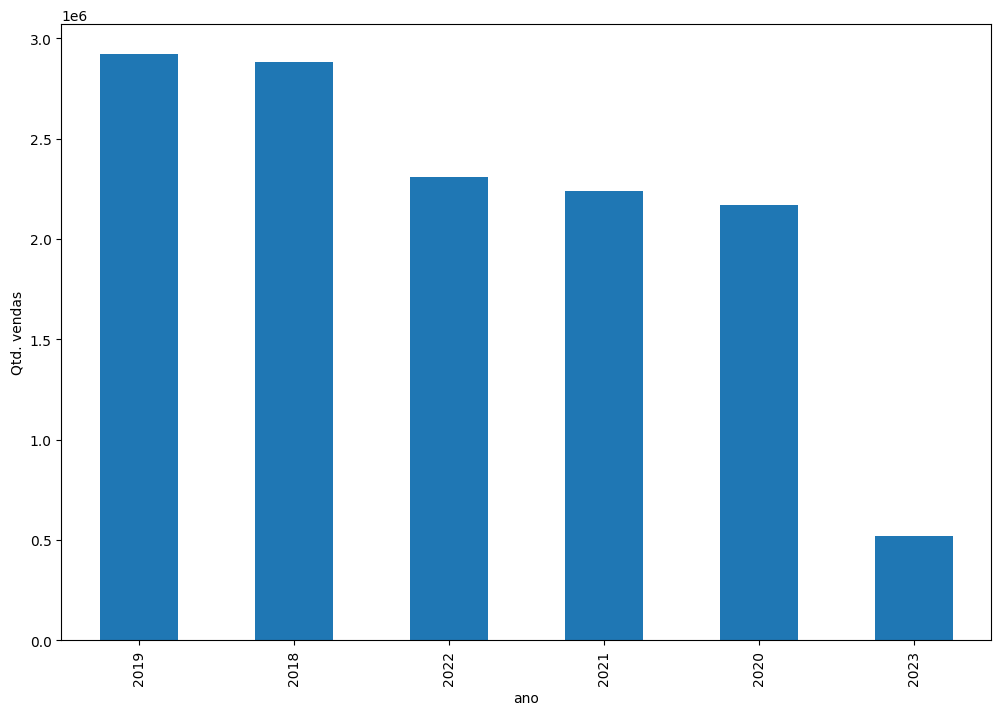

In [ ]:
#Qual foi o ano com o maior número de vendas de autoveículos?
dfPandas.groupby(['ano'])['qtdVendas_veiculosTotal'].sum().sort_values( ascending=False).plot.bar(figsize=(12,8),xlabel='ano',ylabel='Qtd. vendas')

In [ ]:
df.columns

['Producao_veiculos_total',
 'qtdVendas_veiculosTotal',
 'qtdVendas_concesTotal',
 'ano',
 'mes']

<Axes: xlabel='ano', ylabel='Qtd. produção'>

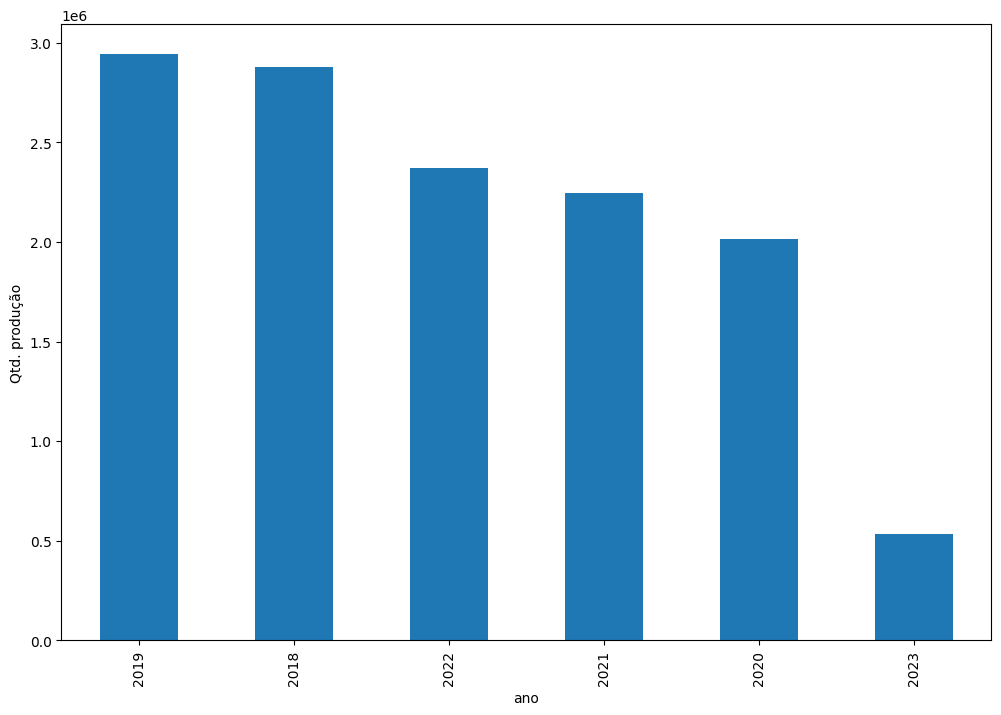

In [ ]:
#Qual foi o ano com a maior produção de autoveículos?
dfPandas.groupby(['ano'])['Producao_veiculos_total'].sum().sort_values( ascending=False).plot.bar(figsize=(12,8),xlabel='ano',ylabel='Qtd. produção')

<Axes: xlabel='ANO', ylabel='Produção de veículos'>

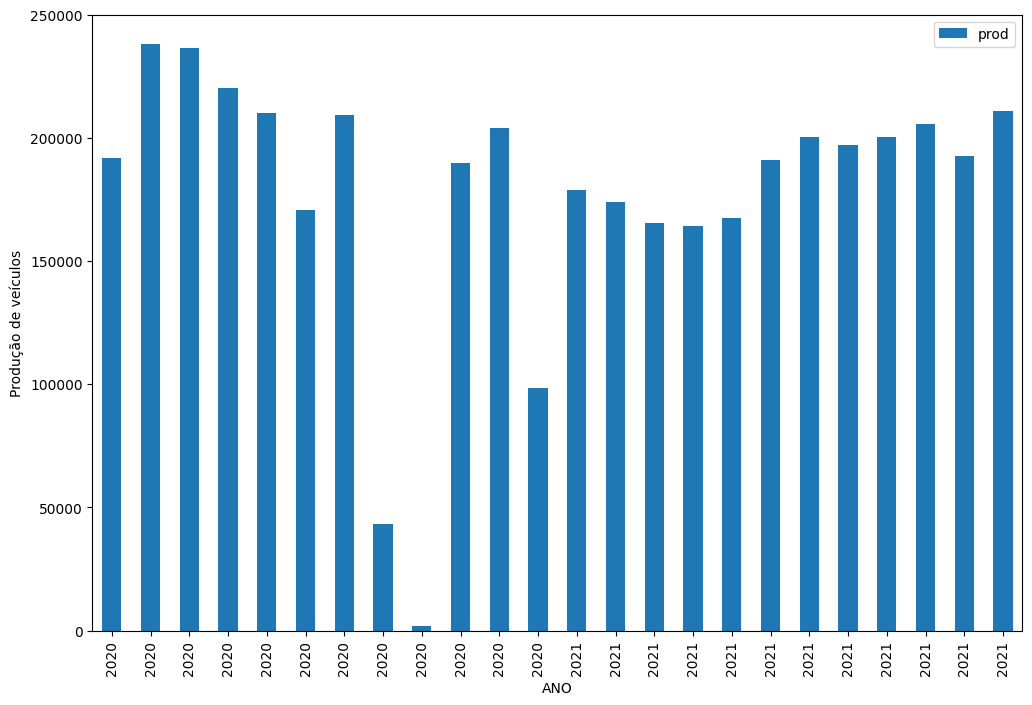

In [ ]:
#Qual foi a produção total de autoveículos nos anos de pandemia?
df2020Pandas.sort_values('ano',ascending=True).plot.bar(figsize=(12,8),xlabel='ANO',ylabel='Produção de veículos')

In [ ]:
df.columns

['Producao_veiculos_total',
 'qtdVendas_veiculosTotal',
 'qtdVendas_concesTotal',
 'ano',
 'mes']

<Axes: xlabel='ano', ylabel='Qtd. vendas concessionárias'>

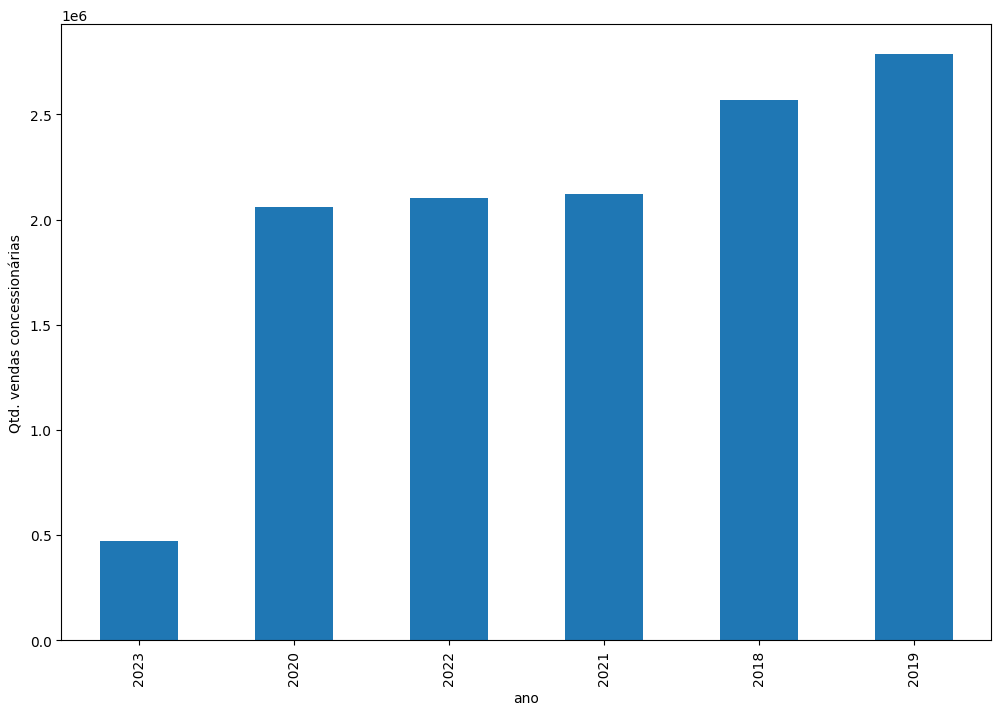

In [ ]:
#Qual foi o ano com o menor número de vendas de carros em concessionárias?
dfPandas.groupby(['ano'])['qtdVendas_concesTotal'].sum().sort_values(ascending=True).plot.bar(figsize=(12,8),xlabel='ano',ylabel='Qtd. vendas concessionárias')